# Poem Generation using FastAI


In this tutorial you will see how to fine-tune a pretrained transformer model from the transformers library by HuggingFace. It can be very simple with FastAI's data loaders. It's possible to use any of the pretrained models from HuggingFace. Below we will experiment with GPT2. 

## Import Libraries


In [3]:
# from fastbook import *
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [4]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

## Read Data
This data is organized by folder. There are two main folders: forms (e.g. haiku, sonnet, etc.) and topics (e.g. love, peace, etc.). Those main folders contain subfolders for the subcategories and then the poem txt files are contained in those.
With fastai, it's quite easy to read the data with the the get_text_files function. You can select all folders or select specific ones.

In [5]:
path = '../input/poemsdataset'

In [6]:
poems = get_text_files(path, folders = ['forms','topics'])
print("There are",len(poems),"poems in the dataset")

There are 20657 poems in the dataset


We'll start off with training the model on ballads. There are only 100 ballads so it won't take as long to train. However you can add more poem forms. For instance, a haiku would be very cool to experiment with and to see if it maintains the 5,7,5 syllable structure. You can also change the path to the topics folder instead of poem forms and you can try out a bunch of poem topics like love, anger, depression, etc.. 

In [7]:
ballads = get_text_files(path+'/forms', folders = ['ballad'])
print("There are",len(ballads),"ballads in the dataset")

There are 100 ballads in the dataset


In [8]:
txt = poems[0].open().read(); #read the first file
print(txt)

Lay a garland on my hearse,
Of the dismal yew,
Maidens, willow branches bear,
Say I died true.
My love was false, but I was firm
From my hour of birth;
Upon my buried body lie
Lightly, gentle earth.


## Prepare the Data



In [9]:
ballads = L(o.open().read() for o in ballads) # to make things easy we will gather all texts in one numpy array

In [10]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt
  
all_ballads = flatten(ballads)

In [11]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [12]:
splits = [range_of(70), range(100)] # use a 70/30 split
tls = TfmdLists(all_ballads, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [13]:
show_at(tls.train, 0)

DOWN harvest headlands the fairy host
Of the poppy banners have flashed and fled,
The lilies have faded like ghost and ghost,
The ripe rose rots in the garden bed.
The grain is garnered, the blooms are shed,
Convolvulus springs on the snowdrop’s bier,
In her stranded gold is the silver thread
Of the first grey hair i’ the head o’ the year.
Like an arrant knave from a bootless boast,
The fire-wind back to his North has sped
To harry the manes of a haunted coast
On a far sea-rim where the stars are dead.
Wistful the welkin with wordless dread,
Mournful the uplands, all ashen sere—
Sad for the snow on a beauteous head—
For the first grey hair i’ the head o’ the year.
Time trysts with Death at the finger-post,
Where the broken issues of life are wed—
Intone no dirges, fill up the toast
To the troops that trip it with silent tread,
Merry we’ll make it tho’ skies be lead,
And March-wind’s moan be a minstrel drear—
A truce to trouble!—we’ll drink instead
To the first grey hair i’ the head o’ 

In [14]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (1170 > 1024). Running this sequence through the model will result in indexing errors


In [15]:
dls.show_batch(max_n=2)

,text,text_
0,"(Non-commissioned Officers in Charge of Prisoners)\nWhen by the labor of my 'ands\nI've 'elped to pack a transport tight\nWith prisoners for foreign lands,\nI ain't transported with delight.\nI know it's only just an' right,\nBut yet it somehow sickens me,\nFor I 'ave learned at Waterval\nThe meanin' of captivity.\nBe'ind the pegged barb-wire strands,\nBeneath the tall electric light,\nWe used to walk in bare-'ead bands,\nExplainin' 'ow we lost our fight;\nAn' that is what they'll do to-night\nUpon the steamer out at sea,\nIf I 'ave learned at Waterval\nThe meanin' of captivity.\nThey'll never know the shame that brands--\nBlack shame no livin' down makes white--\nThe mockin' from the sentry-stands,\nThe women's laugh, the gaoler's spite.\nWe are too bloomin'-much polite,\nBut that is 'ow I'd 'ave us be...\nSince I 'ave learned at Waterval\nThe meanin' of captivity","Non-commissioned Officers in Charge of Prisoners)\nWhen by the labor of my 'ands\nI've 'elped to pack a transport tight\nWith prisoners for foreign lands,\nI ain't transported with delight.\nI know it's only just an' right,\nBut yet it somehow sickens me,\nFor I 'ave learned at Waterval\nThe meanin' of captivity.\nBe'ind the pegged barb-wire strands,\nBeneath the tall electric light,\nWe used to walk in bare-'ead bands,\nExplainin' 'ow we lost our fight;\nAn' that is what they'll do to-night\nUpon the steamer out at sea,\nIf I 'ave learned at Waterval\nThe meanin' of captivity.\nThey'll never know the shame that brands--\nBlack shame no livin' down makes white--\nThe mockin' from the sentry-stands,\nThe women's laugh, the gaoler's spite.\nWe are too bloomin'-much polite,\nBut that is 'ow I'd 'ave us be...\nSince I 'ave learned at Waterval\nThe meanin' of captivity."
1,"Christ should see\nHow men their brothers maim.\nWith bars they blur the gracious moon,\nAnd blind the goodly sun:\nAnd they do well to hide their Hell,\nFor in it things are done\nThat Son of God nor son of Man\nEver should look upon!\nThe vilest deeds like poison weeds,\nBloom well in prison-air;\nIt is only what is good in Man\nThat wastes and withers there:\nPale Anguish keeps the heavy gate,\nAnd the Warder is Despair.\nFor they starve the little frightened child\nTill it weeps both night and day:\nAnd they scourge the weak, and flog the fool,\nAnd gibe the old and grey,\nAnd some grow mad, and all grow bad,\nAnd none a word may say.\nEach narrow cell in which we dwell\nIs a foul and dark latrine,\nAnd the fetid breath of living Death\nChokes up each grated screen,\nAnd all, but Lust, is turned to dust\nIn Humanity's machine.\nThe brackish water that we drink\nCreeps with a loathsome slime,\nAnd the bitter bread they weigh in","should see\nHow men their brothers maim.\nWith bars they blur the gracious moon,\nAnd blind the goodly sun:\nAnd they do well to hide their Hell,\nFor in it things are done\nThat Son of God nor son of Man\nEver should look upon!\nThe vilest deeds like poison weeds,\nBloom well in prison-air;\nIt is only what is good in Man\nThat wastes and withers there:\nPale Anguish keeps the heavy gate,\nAnd the Warder is Despair.\nFor they starve the little frightened child\nTill it weeps both night and day:\nAnd they scourge the weak, and flog the fool,\nAnd gibe the old and grey,\nAnd some grow mad, and all grow bad,\nAnd none a word may say.\nEach narrow cell in which we dwell\nIs a foul and dark latrine,\nAnd the fetid breath of living Death\nChokes up each grated screen,\nAnd all, but Lust, is turned to dust\nIn Humanity's machine.\nThe brackish water that we drink\nCreeps with a loathsome slime,\nAnd the bitter bread they weigh in scales\nIs"


## Fine-tuning the model

In [16]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [17]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [18]:
learn.validate()

(#2) [4.18056583404541,65.40284729003906]

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.14454397559165955)

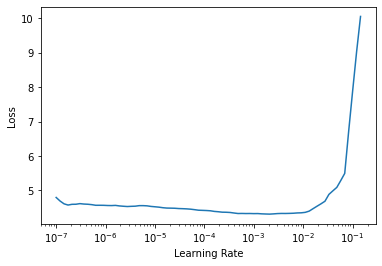

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.199306,3.879428,48.396519,00:36


## Poem Generation Example

In [21]:
prompt = 'love is ridiculous' # create an initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 3])

Adding the `num_beams` and `no_repeat_ngram_size` arguments make a huge difference. This can be explained [here](https://huggingface.co/blog/how-to-generate). Basically beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely num_beams of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability. Without beam search you will obtain a more greedy search. Beam search will always find an output sequence with higher probability than greedy search, but is not guaranteed to find the most likely output. Moreover, without the `no_repeat_ngram_size` you will likely obtain a repeated output. Thus we add a penalty that makes sure that no n-gram appears twice by manually setting the probability of next words that could create an already seen n-gram to 0.

In [22]:
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
love is ridiculous.
But I am not a fool,
I am a man of the world;
And I know that I have a right to be
a man, and that my right is to live a life
that is good for me and for my children.


"I


In [23]:
prompt = "I don't know what I would do"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
I don't know what I would do with my life, but I know that I will never be able to live again.
"I am not a man of the world; I am a human being, and I shall never die."
And he went on to say that he had never been
